# ***Model Traning And Pipeline Creation***

## ***Building pipeline With TfIDF Vectorization***

#### ***Importing Library***

In [4]:
import pandas as pd
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from gensim.models import Word2Vec
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
import joblib
import emoji
import re
from autocorrect import Speller 

from sklearn import set_config
set_config(display='diagram')


In [5]:
# Ensure NLTK downloads are available
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ujjwa_n18433z\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ujjwa_n18433z\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ujjwa_n18433z\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### **Load DataSet**

In [7]:
ds = pd.read_csv("C:\\Users\\ujjwa_n18433z\\Desktop\\ujjwal\\All Projects\\Project_WoC_7.0_Fake_Review_Detection\\fakeReviewData.csv")
ds['category'] = ds['category'].str.replace('_5', '', regex=False)


#### **Text Preprocessor Class**


In [9]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        self.lemmatizer = WordNetLemmatizer()
        self.stopwords = set(stopwords.words("english"))
        return X.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        # Convert emojis to text
        text = emoji.demojize(text, delimiters=("", ""))

        # Handle contractions
        text = re.sub(r"can't", "can not", text)
        text = re.sub(r"won't", "will not", text)
        text = re.sub(r"n't", " not", text)
        text = re.sub(r"'m", " am", text)
        text = re.sub(r"'s", " is", text)
        text = re.sub(r"'re", " are", text)
        text = re.sub(r"'ve", " have", text)
        text = re.sub(r"'d", " would", text)
        text = re.sub(r"'ll", " will", text)

        # Remove URLs and email addresses
        text = re.sub(r"http\S+|www\S+|https\S+", "", text)
        text = re.sub(r"\S*@\S*\s?", "", text)

        # Remove special characters
        text = re.sub(r"[^a-zA-Z0-9\s]", "", text)

        # Remove digits and lowercase
        text = "".join([char.lower() for char in text if not char.isdigit()])

        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))

        # Tokenize
        words = word_tokenize(text)

        # Remove stopwords
        words = [word for word in words if word not in self.stopwords]

        # Lemmatize
        
        words = [self.lemmatizer.lemmatize(word) for word in words]  # Lemmatization

        # Remove multiple spaces
        text = re.sub(r"\s+", " ", " ".join(words)).strip()

        # Rejoin words into a single string
        return text

#### **Encoding Labels**

In [11]:
target_encoder = LabelEncoder()
ds['label'] = target_encoder.fit_transform(ds['label'])  # Encode target (e.g., 'CG' -> 0, 'OR' -> 1)

In [12]:
# Get the mapping
dict(zip(target_encoder.classes_, range(len(target_encoder.classes_))))

{'CG': 0, 'OR': 1}

#### **Creating a Column Transformation**

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ('text', Pipeline([
            ('preprocessor', TextPreprocessor()),
            ('tfidf', TfidfVectorizer(max_features=500))
        ]), 'text_'),
        ('category', OneHotEncoder(handle_unknown='ignore'), ['category']),
        ('rating', StandardScaler(), ['rating'])  # Wrap 'rating' in a list to make it 2D
    ],
    remainder='passthrough'
)

#### **Split the data into training and testing sets**

In [16]:
# Split the data into training and testing sets
X = ds.drop(columns=['label']) 
y = ds['label'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


#### **Define Full Pipeline**

In [18]:
pipelinelg = Pipeline([
    ('preprocessor', preprocessor),                    
    ('classifier', LogisticRegression(random_state=42))  # Logistic Regression
])

In [19]:
pipelinelg

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text',
                                                  Pipeline(steps=[('preprocessor',
                                                                   TextPreprocessor()),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=500))]),
                                                  'text_'),
                                                 ('category',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['category']),
                                                 ('rating', StandardScaler(),
                                                  ['rating'])])),
                ('classifier', LogisticRegression(random_state=42))])

#### **Train, predict and evaluate Logistic Regression**

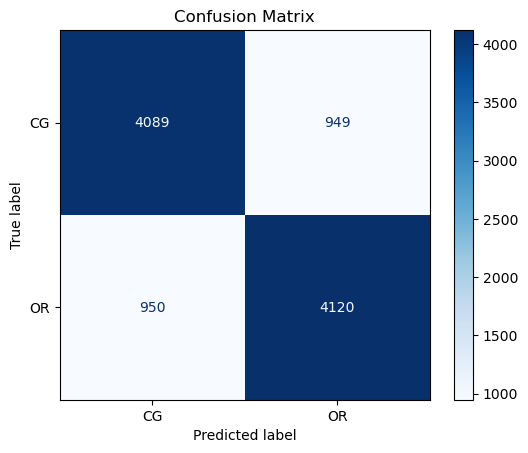

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      5038
           1       0.81      0.81      0.81      5070

    accuracy                           0.81     10108
   macro avg       0.81      0.81      0.81     10108
weighted avg       0.81      0.81      0.81     10108



In [21]:
# Train the pipeline
pipelinelg.fit(X_train, y_train)

# Generate predictions
y_pred = pipelinelg.predict(X_test)

# Create Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(['CG', 'OR']))

# Plot the Confusion Matrix
cmd.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))


#### **Define Support Vector Classifier Pipeline**

In [23]:
pipelinesvm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42))
])

#### **Train, predict and evaluate SVM**

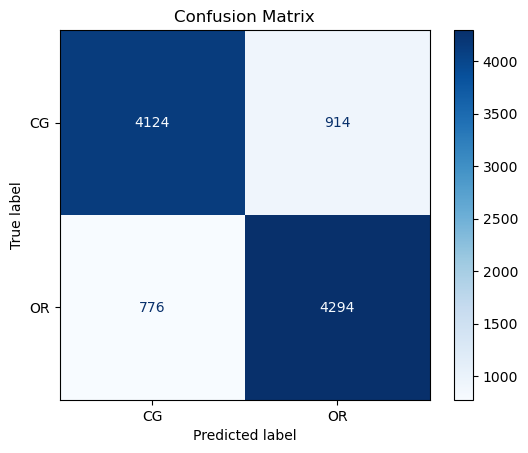

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      5038
           1       0.82      0.85      0.84      5070

    accuracy                           0.83     10108
   macro avg       0.83      0.83      0.83     10108
weighted avg       0.83      0.83      0.83     10108



In [25]:
# Train the pipeline
pipelinesvm.fit(X_train, y_train)

# Generate predictions
y_pred = pipelinesvm.predict(X_test)

# Create Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(['CG', 'OR']))

# Plot the Confusion Matrix
cmd.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

#### **Define Random Forest Classifier Pipeline**

In [27]:

pipelinerf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [28]:
pipelinerf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text',
                                                  Pipeline(steps=[('preprocessor',
                                                                   TextPreprocessor()),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=500))]),
                                                  'text_'),
                                                 ('category',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['category']),
                                                 ('rating', StandardScaler(),
                                                  ['rating'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

#### **Train, predict and evaluate Random Forest**

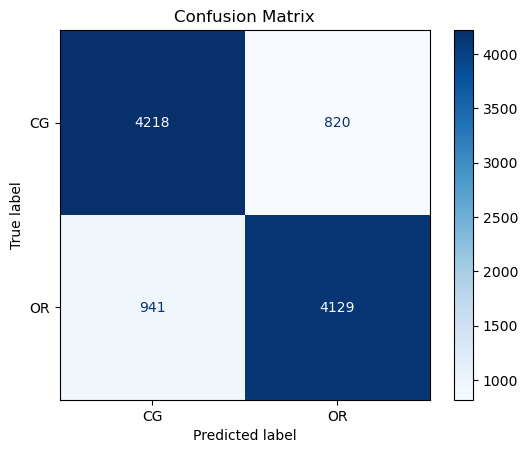

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      5038
           1       0.83      0.81      0.82      5070

    accuracy                           0.83     10108
   macro avg       0.83      0.83      0.83     10108
weighted avg       0.83      0.83      0.83     10108



In [31]:
pipelinerf.fit(X_train, y_train)
 
# Generate predictions
y_pred = pipelinerf.predict(X_test)

# Create Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(['CG', 'OR']))

# Plot the Confusion Matrix
cmd.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

#### **Define Multi Layer Perceptron Classifier Pipeline**

In [35]:

pipelinemlp = Pipeline([
    ('preprocessor', preprocessor),  
    ('classifier', MLPClassifier(
        hidden_layer_sizes=(100, 50),
        activation='relu',           
        solver='adam',               
        max_iter=200,                
        random_state=42,
        early_stopping=True,         
        validation_fraction=0.1      
    ))
])

In [42]:
pipelinemlp

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text',
                                                  Pipeline(steps=[('preprocessor',
                                                                   TextPreprocessor()),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=500))]),
                                                  'text_'),
                                                 ('category',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['category']),
                                                 ('rating', StandardScaler(),
                                                  ['rating'])])),
                ('classifier',
                 MLPClassifier(early_stopping=True,
                               hidden_layer_sizes=(100, 50),
                               random_state=42))])

#### **Train, predict and evaluate MLP**

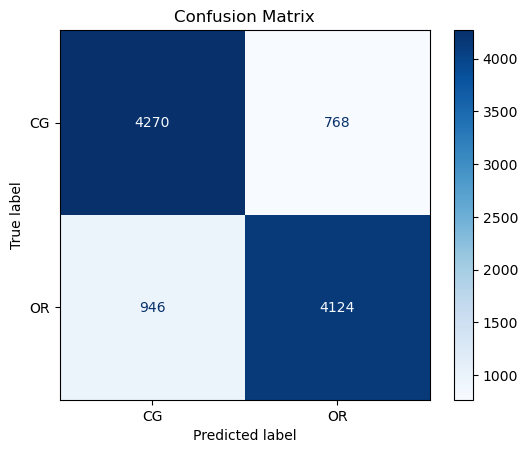

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      5038
           1       0.84      0.81      0.83      5070

    accuracy                           0.83     10108
   macro avg       0.83      0.83      0.83     10108
weighted avg       0.83      0.83      0.83     10108



In [45]:
# Train the pipeline
pipelinemlp.fit(X_train, y_train)
 
# Generate predictions
y_pred = pipelinemlp.predict(X_test)

# Create Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(['CG', 'OR']))

# Plot the Confusion Matrix
cmd.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

## ***Building Pipeline With Embedding*** 

#### **Word2Vec Model Preparation**

In [48]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        self.lemmatizer = WordNetLemmatizer()
        return X.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        # Convert emojis to text
        text = emoji.demojize(text, delimiters=("", ""))

        # Handle contractions
        text = re.sub(r"can't", "can not", text)
        text = re.sub(r"won't", "will not", text)
        text = re.sub(r"n't", " not", text)
        text = re.sub(r"'m", " am", text)
        text = re.sub(r"'s", " is", text)
        text = re.sub(r"'re", " are", text)
        text = re.sub(r"'ve", " have", text)
        text = re.sub(r"'d", " would", text)
        text = re.sub(r"'ll", " will", text)

        # Remove URLs and email addresses
        text = re.sub(r"http\S+|www\S+|https\S+", "", text)
        text = re.sub(r"\S*@\S*\s?", "", text)

        # Remove special characters
        text = re.sub(r"[^a-zA-Z0-9\s]", "", text)

        # Remove digits and lowercase
        text = "".join([char.lower() for char in text if not char.isdigit()])

        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))

        # Tokenize
        words = word_tokenize(text)

        # Lemmatize
        words = [self.lemmatizer.lemmatize(word) for word in words]  # Lemmatization

        # Remove multiple spaces
        text = re.sub(r"\s+", " ", " ".join(words)).strip()

        # Rejoin words into a single string
        return text

In [49]:
class Word2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model=None, vector_size=100):
        self.model = model
        self.vector_size = vector_size
    
    def fit(self, X, y=None):
        if self.model is None:
            sentences = [text.split() for text in X]
            self.model = Word2Vec(sentences, vector_size=self.vector_size, window=5, min_count=1, workers=4)
        return self
    
    def transform(self, X):
        vectors = []
        for text in X:
            words = text.split()
            word_vectors = [self.model.wv[word] for word in words if word in self.model.wv]
            if word_vectors:
                vectors.append(np.mean(word_vectors, axis=0))
            else:
                vectors.append(np.zeros(self.vector_size)) 
        return np.array(vectors, dtype=np.float32) 

#### **Define Column Transformer with Word2Vec**

In [51]:
preprocessor = ColumnTransformer(
    transformers=[
        ('text', Pipeline([
            ('preprocessor', TextPreprocessor()),
            ('word2vec', Word2VecTransformer(vector_size=300))
        ]), 'text_'),
        ('category', OneHotEncoder(handle_unknown='ignore'), ['category']),
        ('rating', StandardScaler(), ['rating'])  
    ],
    remainder='passthrough'
)


#### **Define MLP Pipeline with Word2Vec Preprocessing**

In [53]:

pipelinemlp_word2vec = Pipeline([
    ('preprocessor', preprocessor),  
    ('classifier', MLPClassifier(
        hidden_layer_sizes=(100,50),  
        activation='relu',              
        solver='adam',                
        max_iter=200,               
        random_state=42,
        early_stopping=True,         
        validation_fraction=0.1       
    ))
])

In [54]:
pipelinemlp_word2vec


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text',
                                                  Pipeline(steps=[('preprocessor',
                                                                   TextPreprocessor()),
                                                                  ('word2vec',
                                                                   Word2VecTransformer(vector_size=300))]),
                                                  'text_'),
                                                 ('category',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['category']),
                                                 ('rating', StandardScaler(),
                                                  ['rating'])])),
                ('classifier',
                 MLPClassifier(early_stopping=True,
                               hidden_layer_sizes=(100, 50),
                               random_state=42))])

#### **Train, predict and evaluate MLP with Word2Vec**

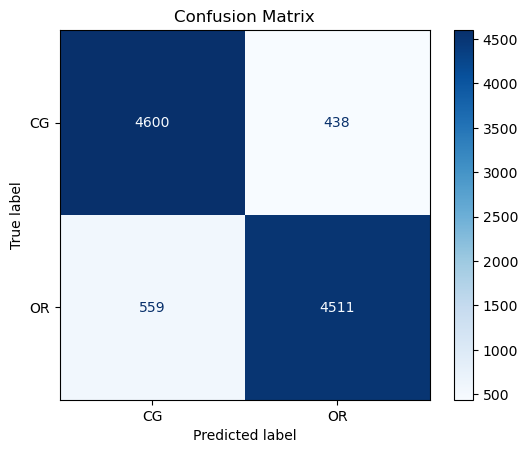

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      5038
           1       0.91      0.89      0.90      5070

    accuracy                           0.90     10108
   macro avg       0.90      0.90      0.90     10108
weighted avg       0.90      0.90      0.90     10108



In [56]:
# Train the pipeline
pipelinemlp_word2vec.fit(X_train, y_train)
 
# Generate predictions
y_pred = pipelinemlp_word2vec.predict(X_test)

# Create Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(['CG', 'OR']))

# Plot the Confusion Matrix
cmd.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

#### **Saving Models**

In [58]:
joblib.dump(pipelinemlp_word2vec, 'best_mlp_word2vec_model.pkl')

['best_mlp_word2vec_model.pkl']

## ***Building Pipeline With Spelling Correction and Embedding*** 

#### **Spelling Correction Class**

In [61]:
class SpellingCorrectionTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        self.lemmatizer = WordNetLemmatizer()
        self.spell=Speller('en')
        return X.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        # Correct Spelling: correct the whole text first
        words = text.split()
        
        corrected_words = [self.spell(word) for word in words]
        text = " ".join(corrected_words)

        # Convert emojis to text
        text = emoji.demojize(text, delimiters=("", ""))

        # Handle contractions
        text = re.sub(r"can't", "can not", text)
        text = re.sub(r"won't", "will not", text)
        text = re.sub(r"n't", " not", text)
        text = re.sub(r"'m", " am", text)
        text = re.sub(r"'s", " is", text)
        text = re.sub(r"'re", " are", text)
        text = re.sub(r"'ve", " have", text)
        text = re.sub(r"'d", " would", text)
        text = re.sub(r"'ll", " will", text)

        # Remove URLs and email addresses
        text = re.sub(r"http\S+|www\S+|https\S+", "", text)
        text = re.sub(r"\S*@\S*\s?", "", text)

        # Remove special characters
        text = re.sub(r"[^a-zA-Z0-9\s]", "", text)

        # Remove digits and lowercase
        text = "".join([char.lower() for char in text if not char.isdigit()])

        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))

        # Tokenize
        words = word_tokenize(text)

        # Lemmatize
        words = [self.lemmatizer.lemmatize(word) for word in words]

        # Remove multiple spaces
        text = re.sub(r"\s+", " ", " ".join(words)).strip()

        # Rejoin words into a single string
        return text

#### **Define Column Transformer with Spelling Correction ,Text Processing ,Word2Vec**

In [63]:
# --- ColumnTransformer ---
text_column = 'text_'
preprocessor = ColumnTransformer(
    transformers=[
        ('text', Pipeline([
            ('spelling', SpellingCorrectionTransformer()),
            ('word2vec', Word2VecTransformer(vector_size=150))
        ]), text_column),
        ('category', OneHotEncoder(handle_unknown='ignore',drop="first"), ['category']),
        ('rating', StandardScaler(), ['rating'])
    ],
    remainder='passthrough'  # or 'drop' if you don't want to keep remaining columns
)

#### **Define MLP Pipeline with Spelling Correction ,Text Processing ,Word2Vec Preprocessing**

In [65]:
pipelinemlp_sc_word2vec = Pipeline([
    ('preprocessor', preprocessor),
    ('model',MLPClassifier(
    hidden_layer_sizes=(150, 70,30),  
    activation='relu',              
    solver='adam',                
    max_iter=200,                  
    random_state=42,
    early_stopping=True,          
    validation_fraction=0.1       
))  
])

In [66]:
pipelinemlp_sc_word2vec

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text',
                                                  Pipeline(steps=[('spelling',
                                                                   SpellingCorrectionTransformer()),
                                                                  ('word2vec',
                                                                   Word2VecTransformer(vector_size=150))]),
                                                  'text_'),
                                                 ('category',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['category']),
                                                 ('rating', StandardScaler(),
                                                  ['rating'])])),
                ('model',
                 MLPClassifier(early_stopping=True,
                               hidden_layer_sizes=(150, 70, 30),
                               random_state=42))])

#### **Train, predict and evaluate MLP with Spelling Correctin and Word2Vec**

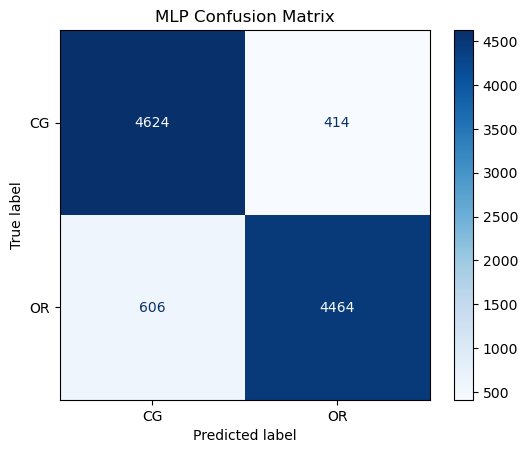

MLP Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      5038
           1       0.92      0.88      0.90      5070

    accuracy                           0.90     10108
   macro avg       0.90      0.90      0.90     10108
weighted avg       0.90      0.90      0.90     10108



In [68]:
# --- Train and Evaluate MLPClassifier ---
pipelinemlp_sc_word2vec.fit(X_train, y_train)
y_pred = pipelinemlp_sc_word2vec.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(['CG', 'OR']))
cmd.plot(cmap=plt.cm.Blues)
plt.title("MLP Confusion Matrix")
plt.show()

print("MLP Classification Report:")
print(classification_report(y_test, y_pred))

## ***Building Pipeline With Pos Tagging and Embedding***

#### **POS Tagger and Encoder Class**

In [71]:

# --- POS Tagger Transformer ---
class PosTaggerTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        pos_tags = []
        for text in X:
            tokens = nltk.word_tokenize(text)
            tags = nltk.pos_tag(tokens)  
            pos_tags.append([tag for word, tag in tags])
        return pos_tags
    

# --- POS Encoder Transformer ---
class PosEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False,drop='first')
        self.is_fitted = False

    def fit(self, X, y=None):
        all_pos_tags = [tag for sublist in X for tag in sublist] 
        self.ohe.fit(np.array(all_pos_tags).reshape(-1, 1)) 
        self.is_fitted = True
        return self

    def transform(self, X):
        if not self.is_fitted:
            raise ValueError("PosEncoderTransformer must be fitted before transform.")
        encoded_pos = []
        for doc_pos_tags in X:
            encoded_tags_for_doc = self.ohe.transform(np.array(doc_pos_tags).reshape(-1, 1))
            encoded_pos.append(encoded_tags_for_doc.mean(axis=0)) #average the encodings
        return np.array(encoded_pos)

#### **Column Creator Class**

In [109]:
class ColumnCreator(BaseEstimator, TransformerMixin):
    def __init__(self, new_column_name, source_column):  
        self.new_column_name = new_column_name
        self.value = source_column
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.new_column_name] = self.value
        return X


#### **Define Column Transformer with Pos Tagger and Encoder ,Text Processing ,Word2Vec**

In [112]:

text_column = 'text_'
preprocessor = ColumnTransformer(
    transformers=[
        ('word2vec', Pipeline([
            ('preprocessor', TextPreprocessor()),
            ('word2vec', Word2VecTransformer(vector_size=150)) 
        ]), text_column),

        ('pos', Pipeline([
            ('preprocessor', TextPreprocessor()),  
            ('pos_tagger', PosTaggerTransformer()), 
            ('pos_encoder', PosEncoderTransformer())
        ]), 'text_pos'),

        ('category', OneHotEncoder(handle_unknown='ignore', drop="first"), ['category']),
        ('rating', StandardScaler(), ['rating'])
    ],
    remainder='passthrough'  
)

#### **Define MLP Pipeline with Pos Tagger and Encoder ,Text Processing ,Word2Vec**

In [115]:
mlp_classifier_pos = Pipeline([
    ('create_text_pos', ColumnCreator(new_column_name='text_pos',source_column='text_')), 
    ('preprocessor', preprocessor),
    ('model', MLPClassifier(
        hidden_layer_sizes=(150, 70, 30),
        activation='relu',
        solver='adam',
        max_iter=200,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1
    ))
])

#### **Train, predict and evaluate MLP With Pos Tagger and Encoder ,Text Processing ,Word2Vec**

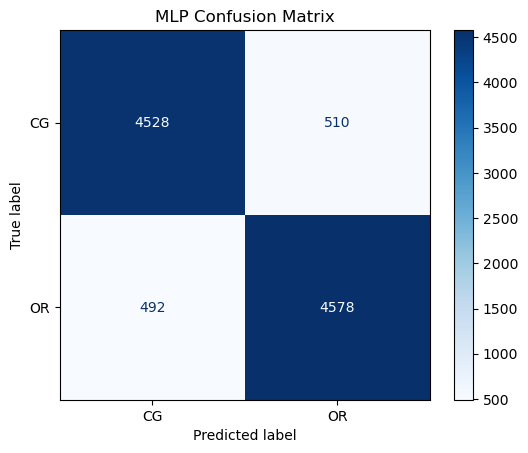

MLP Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      5038
           1       0.90      0.90      0.90      5070

    accuracy                           0.90     10108
   macro avg       0.90      0.90      0.90     10108
weighted avg       0.90      0.90      0.90     10108



In [82]:
# --- Train and Evaluate MLPClassifier ---

mlp_classifier_pos.fit(X_train, y_train)
y_pred = mlp_classifier_pos.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(['CG', 'OR']))
cmd.plot(cmap=plt.cm.Blues)
plt.title("MLP Confusion Matrix")
plt.show()

print("MLP Classification Report:")
print(classification_report(y_test, y_pred))

In [126]:
joblib.dump(mlp_classifier_pos, 'best_mlp_pos.joblib')

['best_mlp_pos.joblib']

In [124]:
joblib.dump(pipelinemlp_sc_word2vec, 'best_mlp_sc_word2vec.joblib')

['best_mlp_sc_word2vec.joblib']